In [ ]:
%%capture
%pip install optuna

import warnings
warnings.filterwarnings('ignore')

import pandas as pd

import matplotlib.pyplot as plt

import optuna

import tensorflow as tf

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, balanced_accuracy_score, precision_recall_curve, average_precision_score, fbeta_score, make_scorer, f1_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve



In [ ]:
column_names = [
    'Status of existing checking account', 'Duration in month', 'Credit history',
    'Purpose', 'Credit amount', 'Savings account/bonds', 'Present employment since',
    'Installment rate in percentage of disposable income', 'Personal status and sex',
    'Other debtors / guarantors', 'Present residence since', 'Property', 'Age in years',
    'Other installment plans', 'Housing', 'Number of existing credits at this bank',
    'Job', 'Number of people being liable to provide maintenance for', 'Telephone',
    'foreign worker', 'Good/Bad'
]

df = pd.read_csv('german.data', delim_whitespace=True, header=None, names=column_names)
df

,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,...,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,foreign worker,Good/Bad
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
categorical_columns = ['Status of existing checking account', 'Credit history', 'Purpose', 'Savings account/bonds',
                        'Present employment since', 'Personal status and sex', 'Other debtors / guarantors',
                        'Property', 'Other installment plans', 'Housing', 'Job', 'Telephone', 'foreign worker']

encoder = OneHotEncoder(drop='first', sparse_output=False).set_output(transform="pandas")

encoder.fit(X_train[categorical_columns])

X_train_encoded = encoder.transform(X_train[categorical_columns])
X_val_encoded = encoder.transform(X_val[categorical_columns])

In [ ]:
numerical_columns = ['Duration in month', 'Credit amount', 'Installment rate in percentage of disposable income', 'Present residence since',
                     'Age in years', 'Number of existing credits at this bank', 'Number of people being liable to provide maintenance for']


scaler = StandardScaler()

X_train_scaled = X_train_encoded.copy()
X_train_scaled[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

X_val_scaled = X_val_encoded.copy()
X_val_scaled[numerical_columns] = scaler.transform(X_val[numerical_columns])

In [ ]:
y_train = y_train - 1
y_val = y_val - 1

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters found: {'colsample_bytree': 1, 'gamma': 0.3, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 50, 'scale_pos_weight': 5.0, 'subsample': 0.7}
Training F2 Score: 0.78
Validation F2 Score: 0.74


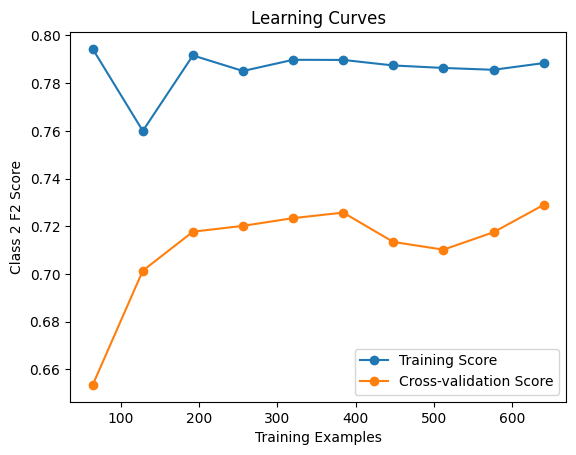

Validation Accuracy: 0.52
Confusion Matrix:
 [[57  2]
 [94 47]]
F2 Score:
Class Good (1): 0.38
Class Bad (2): 0.74
Macro avg: 0.56
Weighted avg: 0.49
Classification Report:
               precision    recall  f1-score   support

    Good (1)       0.96      0.33      0.49       141
     Bad (2)       0.38      0.97      0.54        59

    accuracy                           0.52       200
   macro avg       0.67      0.65      0.52       200
weighted avg       0.79      0.52      0.51       200

Balanced Accuracy: 0.65
AUC-ROC: 0.81


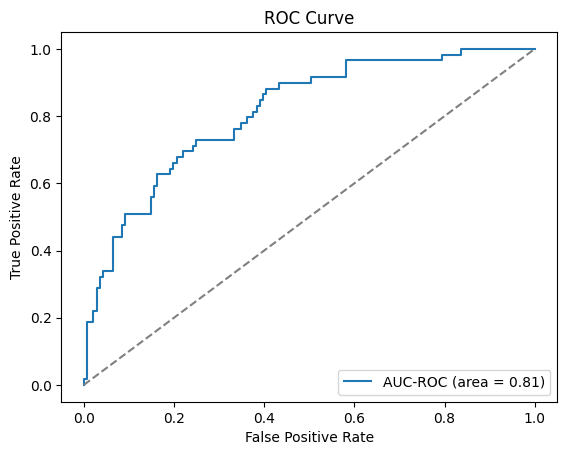

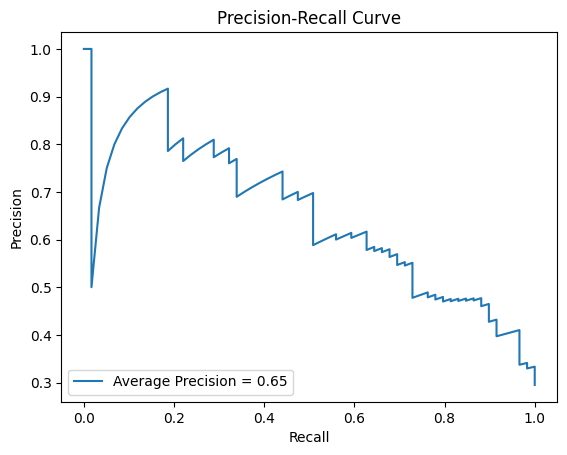

In [ ]:
#BEST MODEL
class_weights = {
    0: 1,
    1: 5
}

scale_pos_weight = class_weights[1] / class_weights[0]
def f2_class_2(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, pos_label=1, average='binary')

f2_scorer_class_2 = make_scorer(f2_class_2)
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 6, 9],
    'subsample': [0.7, 0.8, 1],
    'scale_pos_weight': [scale_pos_weight],
    'colsample_bytree': [0.7, 0.8, 1],
    'gamma': [0, 0.1, 0.3]

}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=f2_scorer_class_2,
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print(f'Best parameters found: {grid_search.best_params_}')

best_xgb_model = grid_search.best_estimator_

y_val_pred = best_xgb_model.predict(X_val_scaled)
y_val_pred_proba = best_xgb_model.predict_proba(X_val_scaled)[:, 1]

y_train_pred = grid_search.best_estimator_.predict(X_train_scaled)
train_f2_score = fbeta_score(y_train, y_train_pred, beta=2, average='binary')

val_f2_score = fbeta_score(y_val, y_val_pred, beta=2, average='binary')

print(f'Training F2 Score: {train_f2_score:.2f}')
print(f'Validation F2 Score: {val_f2_score:.2f}')

train_sizes, train_scores, test_scores = learning_curve(
    best_xgb_model, X_train_scaled, y_train, cv=5,
    scoring=f2_scorer_class_2,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training Score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Cross-validation Score")
plt.xlabel("Training Examples")
plt.ylabel("Class 2 F2 Score")
plt.title("Learning Curves")
plt.legend(loc="best")
plt.show()

accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {accuracy:.2f}')

cm = confusion_matrix(y_val, y_val_pred, labels = [1, 0])
print('Confusion Matrix:\n', cm)

f2_scores = fbeta_score(y_val, y_val_pred, beta=2, average=None)
print('F2 Score:')
print(f'Class Good (1): {round(f2_scores[0], 2)}')
print(f'Class Bad (2): {round(f2_scores[1], 2)}')

f2_score = fbeta_score(y_val, y_val_pred, beta=2, average='macro')
print('Macro avg:', round(f2_score, 2))

f2_score = fbeta_score(y_val, y_val_pred, beta=2, average='weighted')
print('Weighted avg:', round(f2_score, 2))

report = classification_report(y_val, y_val_pred, target_names=['Good (1)', 'Bad (2)'])
print('Classification Report:\n', report)

balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
print(f'Balanced Accuracy: {balanced_acc:.2f}')

roc_auc = roc_auc_score(y_val, y_val_pred_proba)
print(f'AUC-ROC: {roc_auc:.2f}')

fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC-ROC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(y_val, y_val_pred_proba)
avg_precision = average_precision_score(y_val, y_val_pred_proba)
plt.figure()
plt.plot(recall, precision, label=f'Average Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


# hyperparameter tuning: Optuna; classes weights: yes


Best parameters found: {'n_estimators': 282, 'learning_rate': 0.29936170406511875, 'max_depth': 6, 'subsample': 0.8367185465723157, 'colsample_bytree': 0.7926303467220025, 'gamma': 0.10367876152099426}
Validation Accuracy: 0.80
Confusion Matrix:
 [[127  14]
 [ 27  32]]
F2 Score:
Class Good (1): 0.88
Class Bad (2): 0.57
Macro avg: 0.73
Weighted avg: 0.79
Classification Report:
               precision    recall  f1-score   support

    Good (1)       0.82      0.90      0.86       141
     Bad (2)       0.70      0.54      0.61        59

    accuracy                           0.80       200
   macro avg       0.76      0.72      0.74       200
weighted avg       0.79      0.80      0.79       200

Balanced Accuracy: 0.72
AUC-ROC: 0.82


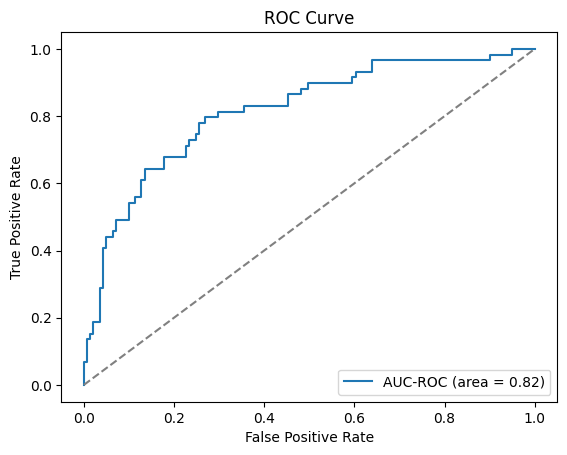

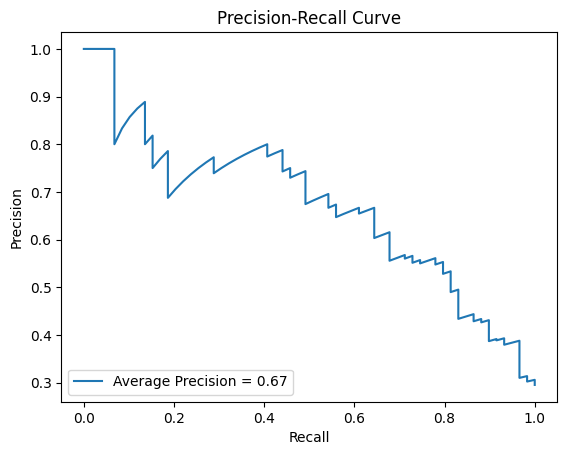

In [ ]:
def f2_weighted(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, average='weighted')

f2_scorer_weighted = make_scorer(f2_weighted)

def objective(trial):
    class_weights = {
        0: 1,
        1: 5
    }
    scale_pos_weight = class_weights[2] / class_weights[1]

    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'scale_pos_weight': scale_pos_weight,
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'random_state': 42
    }

    xgb_model = xgb.XGBClassifier(**param)

    score = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring=f2_scorer_weighted).mean()

    return score

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=100)

print(f'Best parameters found: {study.best_params}')

best_params = study.best_params
best_xgb_model = xgb.XGBClassifier(**best_params)

best_xgb_model.fit(X_train_scaled, y_train)

y_val_pred = best_xgb_model.predict(X_val_scaled)
y_val_pred_proba = best_xgb_model.predict_proba(X_val_scaled)[:, 1]

accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {accuracy:.2f}')

cm = confusion_matrix(y_val, y_val_pred, labels = [1,0])
print('Confusion Matrix:\n', cm)

f2_scores = fbeta_score(y_val, y_val_pred, beta=2, average=None)
print('F2 Score:')
print(f'Class Good (1): {round(f2_scores[0], 2)}')
print(f'Class Bad (2): {round(f2_scores[1], 2)}')

f2_score = fbeta_score(y_val, y_val_pred, beta=2, average='macro')
print('Macro avg:', round(f2_score, 2))

f2_score = fbeta_score(y_val, y_val_pred, beta=2, average='weighted')
print('Weighted avg:', round(f2_score, 2))

report = classification_report(y_val, y_val_pred, target_names=['Good (1)', 'Bad (2)'])
print('Classification Report:\n', report)

balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
print(f'Balanced Accuracy: {balanced_acc:.2f}')

roc_auc = roc_auc_score(y_val, y_val_pred_proba)
print(f'AUC-ROC: {roc_auc:.2f}')

fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC-ROC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(y_val, y_val_pred_proba)
avg_precision = average_precision_score(y_val, y_val_pred_proba)
plt.figure()
plt.plot(recall, precision, label=f'Average Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
